# Train model on training+validation data set and evaluate model on test set
## Import packages

In [3]:
import torch
from torch import sigmoid
from torch.nn import Linear
import torch.nn.init as nn_init
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib as matplt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import os
from os import path
from sklearn.metrics import roc_auc_score
import datetime
import time
import importlib

path_join = path.join

%matplotlib inline

torch.manual_seed(0)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

## User inputs

In [4]:
ALL_IMAGE_DIR = '/Users/marcustan/Data/ChestXray14/images'; # directory containing all images
BASE_PATH_LABELS = './labels'; # training, validation and test lists

TRAIN_LISTS = ['train_val_A.csv']
TEST_LISTS = ['test_A.csv']

# Output directory for the training, validation, test statistics
# MODEL_NAME followed by a date-time stamp will be added to 
# MODEL_BASE_PATH
MODEL_BASE_PATH = '../out-test-sigmoid-lr0p01'

MODEL_NAME = 'densenet121'
#MODEL_NAME = 'resnet50'
#MODEL_NAME = 'densenet121attA'
#MODEL_NAME = 'densenet121attB'

# Classes to use for the image labels
# Note: there must be at least 14 classes
CLASSES = ['No Finding', 'Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 
          'Atelectasis', 'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

#BATCH_SIZE = 8
BATCH_SIZE = 16
#BATCH_SIZE = 32

TRAIN_EPOCH = 8

LEARNING_RATE = 0.01
MOMENTUM = 0.9
SEED = 0

REINITIALIZE_METHOD = None; # do not reset pretrained weights
#REINITIALIZE_METHOD = 'xavierNormal'; # reset all weights

##  Load training and test data

In [5]:
# Set seed
np.random.seed(SEED)
torch.manual_seed(SEED)

CLASSES = np.array(CLASSES)
# Define custom dataset
class CustomDataset(Dataset):
    def __init__(self, im_dir, im_names, im_labels, im_transforms=None):
        self.im_dir = im_dir
        self.im_labels = im_labels
        self.im_names = im_names
        if im_transforms:
            self.im_transforms = im_transforms
        else:
            self.im_transforms = transforms.Compose([transforms.ToTensor()])

    def __len__(self):
        
        return len(self.im_labels)

    def __getitem__(self, idx):
        im_file = os.path.join(self.im_dir,
                               self.im_names[idx])
        #print(im_file)
        im = Image.open(im_file).convert('RGB')

        im = self.im_transforms(im)
        
        return im, self.im_labels[idx]

def load_data(all_image_dir, train_lists, base_path_labels, classes, batchsize, im_transforms):
    train_sets = []
    train_loaders = []
    for train_list in train_lists:
        full_path_list = path_join(base_path_labels, train_list)
        df = pd.read_csv(full_path_list)
        im_names = df['Image'].to_numpy()
        im_labels = torch.tensor(df[classes].to_numpy(), dtype=torch.float)
        #assert im_labels.shape[1] == n_classes, 'Number of classes from train list not consistent with provided N_CLASSES'
        train_sets.append(CustomDataset(all_image_dir, im_names, im_labels, im_transforms))
        train_loaders.append(DataLoader(train_sets[-1], batch_size=batchsize, shuffle=True))
        print('Size for {0} = {1}'.format(train_list, len(im_names)))
    
    return train_loaders
    
# Load data

im_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training and test loaders
train_loaders = load_data(ALL_IMAGE_DIR, TRAIN_LISTS, BASE_PATH_LABELS, CLASSES, BATCH_SIZE, im_transforms)
test_loaders = load_data(ALL_IMAGE_DIR, TEST_LISTS, BASE_PATH_LABELS, CLASSES, BATCH_SIZE, im_transforms)


Size for train_val_A.csv = 16944
Size for test_A.csv = 6112


## Visualize some training images

Visualize training images ...
Training set 0


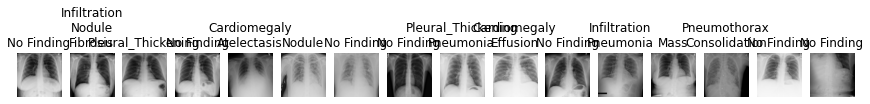

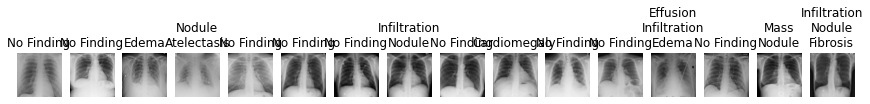

In [6]:
# Visualize some of the images and show corresponding labels
def show_batch_images(dataloader_iter, classes):
    images, labels = next(dataloader_iter)
    fig, axes = plt.subplots(1, len(images), figsize=(15, 7))
    
    im_mean = torch.tensor([0.485, 0.456, 0.406])
    im_std = torch.tensor([0.229, 0.224, 0.225])
    
    
    for count, (im, label) in enumerate(zip(images, labels)):
        ax = axes[count]
        im = im.permute(1, 2, 0)
        # un-normalized the image
        im.mul_(im_std).add_(im_mean); # inplace multiplication and addition
        im = im.numpy()
        
        # The normalize code -> t.sub_(m).div_(s)
        ax.imshow(im, vmin=0, vmax=1)
        ax.axis('off')
        idx = label.nonzero().squeeze(1).numpy()
        if len(idx):
            class_names = classes[idx]
            title = '\n'.join(list(class_names))
        else:
            title = 'No Finding'

        ax.set_title(title)
        
        
print('Visualize training images ...')
for count, loader in enumerate(train_loaders):
    loader_iter = iter(loader)
    print('Training set {0}'.format(count))
    for i in range(2):
        show_batch_images(loader_iter, CLASSES)


## Initialize model

In [7]:
def initialize_model(model_name, reinitialize_method):
    if  'densenet121att' in model_name:
        model_module = importlib.import_module(model_name)
        #print(model_module)
        model = getattr(model_module, model_name)(pretrained=True, 
                                                  num_classes=len(CLASSES))
        #model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, len(CLASSES)), 
        #                                 nn.Softmax(dim=1))
        model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, len(CLASSES)), 
                                         nn.Sigmoid())
        # Initialize the weights of the classifier layer 
        print('Initialize weights of classifier layer')
        for m in model.classifier.modules():
            if isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)

    elif 'densenet' in model_name:
        import densenet_models
        importlib.reload(densenet_models)
        #model = densenet121(pretrained=True)
        model = getattr(densenet_models, model_name)(pretrained=True)
        #model.classifier = nn.Sequential(nn.Linear(1024, len(CLASSES)), nn.Softmax(dim=1))
        model.classifier = nn.Sequential(nn.Linear(model.classifier.in_features, len(CLASSES)), 
                                         nn.Sigmoid())
        # Initialize the weights of the classifier layer 
        print('Initialize weights of classifier layer')
        for m in model.classifier.modules():
            if isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)

    elif 'resnet' in model_name:
        import resnet_models
        importlib.reload(resnet_models)
        #model = resnet50(pretrained=True)
        model = getattr(resnet_models, model_name)(pretrained=True)
        #model.fc = nn.Sequential(nn.Linear(model.fc.in_features, len(CLASSES)), 
        #                         nn.Softmax(dim=1))
        model.fc = nn.Sequential(nn.Linear(model.fc.in_features, len(CLASSES)), 
                                 nn.Sigmoid())
        # Initialize the weights of the classifier layer 
        print('Initialize weights of classifier layer')
        model_fc = model.fc
        for m in model_fc.modules():
            if isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)
    else:
        raise NotImplementedError('Unknown model name')
        
    if reinitialize_method == None:
        pass
    elif reinitialize_method == 'xavierNormal':
        print('!!!!!! Reinitialize weights with xavier normal !!!!!!')
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                nn_init.xavier_normal_(m.weight, gain=1)
                if m.bias is not None:
                    nn_init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn_init.normal_(m.weight, 0, 0.01)
                nn_init.constant_(m.bias, val=0.)
            elif isinstance(m, nn.Linear):
                nn_init.xavier_normal_(m.weight, gain=1)
                if m.bias is not None:
                    nn_init.constant_(m.bias, val=0.)
    else:
        raise NotImplementedError('Unknown initialization method')
        

    return model 

model = initialize_model(MODEL_NAME, REINITIALIZE_METHOD)


loader_iter = iter(train_loaders[0])
images, labels = next(loader_iter)


print('{0} model output test'.format(MODEL_NAME))
#print(images[0, 0, 0, :5])
y_hat = model(images)
n_params = sum(p.numel() for p in model.parameters())
print('number of parameters = ', n_params)
print(y_hat[0])


Initialize weights of classifier layer
densenet121 model output test
number of parameters =  6969231
tensor([0.8981, 0.7129, 0.6944, 0.5039, 0.3501, 0.5366, 0.2228, 0.4723, 0.4336,
        0.7440, 0.7118, 0.4628, 0.5069, 0.4175, 0.0644],
       grad_fn=<SelectBackward>)


## Train model and evaluate on test set

In [ ]:
def make_dir_if_not_exist(folder):
    try:
        os.makedirs(folder)
    except:
        pass
    
def train_model(model, train_loader, device, n_epoch, optimizer, criterion, model_base_path, split=0):
    start_time = time.time()
    
    model.train() # prep model for training
    
    n_batches = len(train_loader)
    Ypred = []
    Ytruth = []
    stats = {'all_loss': [], 'epoch_end_ind': [], 'epoch_loss': [], 
             'epoch_auroc_ave': [], 'epoch_auroc_classes': []}

    #max_count = 2; # for debugging
    
    for epoch in range(n_epoch):
        curr_epoch_loss = []
        for count, (data, target) in enumerate(train_loader):

            data = data.to(device)
            target = target.to(device)
            # data = data.to(device)
            
            # Step 1. clear gradients 
            optimizer.zero_grad()
            # Step 2. perform forward pass using `model`, save the output to y_hat;
            # Convert output to probability vector using softmax function
            ypred = model(data)
            #ypred = F.softmax(ypred, dim=1)
            Ypred.append(ypred.detach().cpu().numpy())
            Ytruth.append(target.detach().cpu().numpy())
            # Step 3. calculate the loss using `criterion`, save the output to loss.
            loss = criterion(ypred, target)
            # Step 4. backward pass 
            loss.backward()
            # Step 5. optimization 
            optimizer.step()
            # Step 6. record loss
            loss_scalar = float(loss.detach().cpu().numpy())
            curr_epoch_loss.append(loss_scalar)
            stats['all_loss'].append(loss_scalar)
            
            if count % 10 == 0:
                print('Split {0}, Epoch {1}, Batch {2}/{3}: elapsed {4:.2f}s,'
                      'batch loss {5:g}, curr mean epoch loss {6:g}'
                      ''.format(split, epoch, count + 1, n_batches, time.time() - start_time,
                                loss_scalar, np.mean(curr_epoch_loss)))
            
            # for debugging
            #if count >= max_count:
            #    break
                          
        Ypred1 = np.concatenate(Ypred, axis=0)
        Ytruth1 = np.concatenate(Ytruth, axis=0)
        try:
            auroc_ave =  roc_auc_score(Ytruth1, Ypred1, average='weighted')
            auroc_classes = roc_auc_score(Ytruth1, Ypred1, average=None)
        except ValueError:
            print('WARNING: AUC undefined as only one sample is available for 1 or more of the classes')
            auroc_ave = 0.0
            auroc_classes = np.zeros(target.shape[1])
            
        stats['epoch_auroc_ave'].append(auroc_ave)
        stats['epoch_auroc_classes'].append(auroc_classes)
        stats['epoch_end_ind'].append(len(stats['all_loss'])-1)
        mean_epoch_loss = np.mean(curr_epoch_loss)
        stats['epoch_loss'].append(mean_epoch_loss)
        print('Epoch {0}: elapsed {1:.2f}s, curr mean epoch loss={2:g},'
              'curr average auroc={3:g}'.format(epoch, time.time() - start_time,
                                              mean_epoch_loss, auroc_ave))
        auroc_classes_dict = dict(zip(CLASSES, np.round(auroc_classes, 3)))
        print('Class auroc = ', auroc_classes_dict)
        print('Saving model ...')

        model_file = path_join(model_base_path, 'model_split'+str(split)+'_epoch' + str(epoch))
        torch.save(model.state_dict(), model_file) 
        # for debugging
        #if count >= 3:
        #    break
                        
    return model, stats



def eval_model(model, dataloader, device):

    model.eval()
    Ypred = []
    Ytruth = []
    n_batches = len(dataloader)
    #max_count = 3; # for debugging
    for count, (data, truth) in enumerate(dataloader):
        data = data.to(device)
        truth = truth.to(device)
        if count % 10 == 0:
            print('Batch {0}/{1}'.format(count+1, n_batches))
        ypred = model(data)
        #ypred = ypred.softmax(dim=1)
        Ypred.append(ypred.detach().cpu().numpy())
        Ytruth.append(truth.detach().cpu().numpy())
        #if count >= max_count:
        #    break
        
    Ypred = np.concatenate(Ypred, axis=0)

    Ytruth = np.concatenate(Ytruth, axis=0)

    try:
        auroc_ave =  roc_auc_score(Ytruth, Ypred, average='weighted')
        auroc_classes = roc_auc_score(Ytruth, Ypred, average=None)
    except ValueError:
        print('WARNING: AUC undefined as only one sample is available for 1 or more of the classes')
        auroc_ave = 0.0
        auroc_classes = np.zeros(truth.shape[1])
        
    return auroc_ave, auroc_classes

criterion = nn.BCELoss()
#criterion = nn.CrossEntropyLoss()

n_epochs = TRAIN_EPOCH

datetime1 = datetime.datetime

# Directory for saving the models and output stats
time_stamp = datetime1.now().strftime("%Y-%m-%d-%H-%M-%S")
model_dir = MODEL_BASE_PATH + '-' + MODEL_NAME + '-' + time_stamp 
make_dir_if_not_exist(model_dir)

test_stats = pd.DataFrame(columns=['Split', 'File', 'Ave AUROC', *CLASSES])
train_stats = pd.DataFrame(columns=['Split', 'File', 'Epoch', 'Epoch_loss', 'Epoch_AUROC', *CLASSES])
train_loss = pd.DataFrame(columns=['Split', 'Batch_loss'])

fig1, ax1 = plt.subplots(figsize=(15, 7))
matplt.rcParams.update({'font.size': 16})
lnstyles = ['-o', '-^', '-v', '-<', '->', '-h',
            '--o', '--^', '--v', '--<', '-->', '--h',
            '-.o', '-.^', '-.v', '-.<', '-.>', '-.h']

for split, (train_loader, test_loader) in enumerate(zip(train_loaders, test_loaders)):
    print('\n********Split = ', split, ', training model ...')
    # Train model
    start_time_tot = time.time()
    
    # Re-initialize model for every split
    model = initialize_model(MODEL_NAME, REINITIALIZE_METHOD)
    

    # Must reset optimizer whenever model is re-initialized
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    #optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        model.cuda()
    
    
    model, stats = train_model(model, train_loader, DEVICE, n_epochs, 
                               optimizer, criterion, model_dir, split)
    print('Total training time {0:.2f}s'.format(time.time() - start_time_tot))
    
    # Save training stats in data frame
    row_start = split*n_epochs
    row_end = (split+1)*n_epochs
    for count, row in enumerate(range(row_start, row_end)):
        train_stats.loc[row] = [split, TRAIN_LISTS[split], count, stats['epoch_loss'][count], stats['epoch_auroc_ave'][count],
                                *list(stats['epoch_auroc_classes'][count])]
    out_file = path_join(model_dir, 'train_stats.csv')

    train_stats.to_csv(out_file, index=False)
    print(train_stats)
    train_loss = train_loss.append(pd.DataFrame({'Split': split, 'Batch_loss': stats['all_loss']}))
    out_file = path_join(model_dir, 'train_loss.csv')
    train_loss.to_csv(out_file)
 
    # Plot training statistics
    str_prefix = 'Split_' + str(split)
    iterx = np.arange(len(stats['all_loss']))
    epoch_end_ind = np.array(stats['epoch_end_ind'])
    ax1.plot(iterx, stats['all_loss'], '--', label=str_prefix)
    ax1.plot(iterx[epoch_end_ind], stats['epoch_loss'], 'o-', label=str_prefix)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss')
    ax1.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'train_loss.png')
    fig1.savefig(out_file)
    
    fig2, ax2 = plt.subplots(figsize=(15, 7))
    epochs = np.arange(n_epochs)
    ax2.plot(epochs, stats['epoch_auroc_ave'], 's-', label='Ave')
    for jj, name in enumerate(CLASSES):
        ax2.plot(epochs, train_stats.loc[train_stats['Split']==split, name], 
                lnstyles[jj], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_xlim(-0.1, n_epochs)
    ax2.set_ylabel('AUROC')
    ax2.set_title(str_prefix)
    ax2.legend(prop={'size': 16})
    out_file = path_join(model_dir, 'split'+str(split)+'_train_auroc.png')
    fig2.savefig(out_file)
    # Validate model
    start_time_tot = time.time()
    print('\n********Testing model ...')
    auroc_ave, auroc_classes = eval_model(model, test_loader, DEVICE)
    print('Total test time {0:.2f}s'.format(time.time() - start_time_tot))
    #print('Val average auroc={0:g}'.format(auroc_ave))
    #auroc_classes_dict = dict(zip(CLASSES, np.round(auroc_classes,3)))
    #print('Val class auroc=', auroc_classes_dict)
    
    # Save validation stats in a data frame
    test_stats.loc[split] = [split, TEST_LISTS[split], auroc_ave, *auroc_classes]
    out_file = path_join(model_dir, 'test_stats.csv')
    # Stack the class AUROC
    test_stats_stacked = pd.melt(test_stats, id_vars=['Split', 'File'], var_name='Class', value_name='AUROC')
    test_stats_stacked.to_csv(out_file, index=False)
    print(test_stats_stacked)


********Split =  0 , training model ...
Initialize weights of classifier layer
Split 0, Epoch 0, Batch 1/1059: elapsed 10.56s,batch loss 0.747334, curr mean epoch loss 0.747334
